In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix

In [49]:
import seaborn as sns

## Model

In [2]:
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cab

## Input data

In [3]:
train_df =  pd.read_csv('train.csv', sep=',', engine='python')
df_test = pd.read_csv('test.csv')
df_test['Weather'] = np.zeros((len(df_test),))

### Dir Maerge

In [4]:
train_end_id = len(train_df)
df = pd.concat([train_df, df_test ], sort=False, ignore_index=True)

In [5]:
list_lat = np.load('list_lat.npy',allow_pickle='TRUE').item()

In [6]:
list_long = np.load('list_long.npy',allow_pickle='TRUE').item()

In [7]:
df['loc_lat']=df['Loc'].map(list_lat)
df['loc_long']=df['Loc'].map(list_long)

In [8]:
df

,Date,Loc,TempLow,TempHigh,Steaming,Sun,WindDir,WindSpeed,DayWindDir,NightWindDir,...,DayPressure,NightPressure,DayCloud,NightCloud,DayTemp,NightTemp,Weather,RISK_MM,loc_lat,loc_long
0,2016/7/19,NaN,19.5,NaN,5.69496,0.500000,ENE,61.0,ENE,ENE,...,1020.4,1021.9,NaN,7.00000,NaN,19.6,0.0,NaN,NaN,NaN
1,2010/7/26,Canberra,2.1,15.7,NaN,5.700000,E,26.0,NaN,SE,...,1023.7,1020.8,4.000000,1.00000,9.0,14.1,0.0,0.0,-35.297591,149.101268
2,2014/4/2,Woomera,20.9,36.1,5.69496,NaN,S,39.0,S,SW,...,1017.1,1014.9,4.167266,4.27812,24.2,33.9,0.0,0.0,-31.199914,136.825353
3,2014/11/19,Tuggeranong,11.5,23.9,5.69496,7.993227,NNE,35.0,W,NaN,...,1010.2,NaN,4.167266,4.27812,13.8,21.8,1.0,0.2,-35.420977,149.092134
4,NaN,Hobart,8.2,20.5,3.20000,NaN,N,69.0,N,WNW,...,NaN,1001.2,7.000000,7.00000,NaN,17.6,0.0,0.6,-42.882509,147.328123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2011/12/27,NaN,9.6,21.5,8.00000,12.000000,SSW,31.0,ESE,SE,...,1024.5,1022.8,0.000000,6.00000,14.3,19.0,0.0,0.0,NaN,NaN
69996,NaN,Canberra,11.6,31.4,5.69496,7.993227,NNE,39.0,NaN,SE,...,1019.1,1016.3,4.167266,4.27812,19.3,NaN,0.0,0.0,-35.297591,149.101268
69997,2011/1/22,Moree,22.2,34.5,NaN,7.600000,NNE,39.0,NNE,N,...,NaN,1008.5,7.000000,7.00000,25.2,NaN,0.0,0.0,-29.461720,149.840715
69998,2010/10/2,Mildura,16.4,43.5,7.00000,12.700000,ENE,43.0,NaN,NaN,...,1014.2,1010.5,0.000000,4.27812,28.9,NaN,0.0,NaN,-34.184726,142.162497


### Processing Date

In [9]:
df_loc=df.copy()

In [10]:
df_loc['Date']=df_loc['Date'].fillna("0")

In [11]:
def replace_string(x):
    if(x!="0"):
        tmp=x.split("/")
        #print(tmp)
        rx=int(tmp[0])*10000+int(tmp[1])*100+int(tmp[2])
        return rx
    else:
        return int(x)

In [12]:
df_loc['Date']=df_loc['Date'].apply(lambda x: replace_string(x))
df_loc['Date']=df_loc['Date'].replace(0,np.nan)

###### Testing

In [63]:
df_loc.loc[[503],:]

,Date,Loc,TempLow,TempHigh,Steaming,Sun,WindDir,WindSpeed,DayWindDir,NightWindDir,...,DayPressure,NightPressure,DayCloud,NightCloud,DayTemp,NightTemp,Weather,RISK_MM,loc_lat,loc_long
503,20130403.0,NaN,NaN,NaN,NaN,NaN,NNW,NaN,ESE,NaN,...,NaN,1001.6,6.0,NaN,31.5,NaN,0.0,0.0,NaN,NaN


#### Drop directions

In [442]:
df_preprocessed=df_loc.copy()

In [443]:
cols = ["WindDir","DayWindDir","NightWindDir"]
for item in cols:
    df_preprocessed[item] = df_loc[item].astype("category").cat.codes +1

In [444]:
df_preprocessed=df_preprocessed.drop(columns = ['Loc',"DayWindDir","NightWindDir"])

#### One

In [364]:
df_preprocessed=df_preprocessed.drop(columns = ['Loc',"DayWindDir","NightWindDir"])

In [365]:
df_preprocessed = pd.get_dummies(df_preprocessed)

In [445]:
df_preprocessed = df_preprocessed.fillna(df_preprocessed.median())

### Imputation of Missing

In [340]:
df_preprocessed

,Date,TempLow,TempHigh,Steaming,Sun,WindSpeed,DayWindSpeed,NightWindSpeed,DayHumidity,NightHumidity,...,WindDir_NNW,WindDir_NW,WindDir_S,WindDir_SE,WindDir_SSE,WindDir_SSW,WindDir_SW,WindDir_W,WindDir_WNW,WindDir_WSW
0,20160719.0,19.5,NaN,5.69496,0.500000,61.0,31.0,22.0,86.641375,41.810006,...,0,0,0,0,0,0,0,0,0,0
1,20100726.0,2.1,15.7,NaN,5.700000,26.0,9.0,7.0,53.275715,76.598048,...,0,0,0,0,0,0,0,0,0,0
2,20140402.0,20.9,36.1,5.69496,NaN,39.0,31.0,17.0,15.471574,52.163254,...,0,0,1,0,0,0,0,0,0,0
3,20141119.0,11.5,23.9,5.69496,7.993227,35.0,7.0,17.0,46.442398,67.664733,...,0,0,0,0,0,0,0,0,0,0
4,NaN,8.2,20.5,3.20000,NaN,69.0,NaN,NaN,51.830889,51.770240,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,20111227.0,9.6,21.5,8.00000,12.000000,31.0,17.0,9.0,39.878487,57.490952,...,0,0,0,0,0,1,0,0,0,0
69996,NaN,11.6,31.4,5.69496,7.993227,39.0,7.0,NaN,NaN,70.743790,...,0,0,0,0,0,0,0,0,0,0
69997,20110122.0,22.2,34.5,NaN,7.600000,39.0,26.0,NaN,30.743840,64.412890,...,0,0,0,0,0,0,0,0,0,0
69998,20101002.0,16.4,43.5,7.00000,12.700000,43.0,19.0,19.0,28.084916,63.565166,...,0,0,0,0,0,0,0,0,0,0


### Other

In [112]:
from sklearn.impute import KNNImputer

In [114]:
imputer = KNNImputer()

In [116]:
imputer.fit(df_preprocessed)

KNNImputer()

In [117]:
df_preprocessed_kn: pd.DataFrame = imputer.transform(df_preprocessed)

In [121]:
df_preprocessed_kn: pd.DataFrame=df_preprocessed_kn

In [123]:
df_preprocessed.columns

Index(['Date', 'TempLow', 'TempHigh', 'Steaming', 'Sun', 'WindDir',
       'WindSpeed', 'DayWindSpeed', 'NightWindSpeed', 'DayHumidity',
       'NightHumidity', 'DayPressure', 'NightPressure', 'DayCloud',
       'NightCloud', 'DayTemp', 'NightTemp', 'Weather', 'RISK_MM', 'loc_lat',
       'loc_long'],
      dtype='object')

In [125]:
df_preprocessed_knn=pd.DataFrame(data=df_preprocessed_kn, columns=df_preprocessed.columns) 

In [122]:
df_preprocessed_kn

array([[ 2.01607190e+07,  1.95000000e+01,  2.11200000e+01, ...,
         1.77600000e+01, -3.89154776e+01,  1.45319016e+02],
       [ 2.01007260e+07,  2.10000000e+00,  1.57000000e+01, ...,
         0.00000000e+00, -3.52975906e+01,  1.49101268e+02],
       [ 2.01404020e+07,  2.09000000e+01,  3.61000000e+01, ...,
         0.00000000e+00, -3.11999142e+01,  1.36825353e+02],
       ...,
       [ 2.01101220e+07,  2.22000000e+01,  3.45000000e+01, ...,
         0.00000000e+00, -2.94617202e+01,  1.49840715e+02],
       [ 2.01010020e+07,  1.64000000e+01,  4.35000000e+01, ...,
         0.00000000e+00, -3.41847265e+01,  1.42162497e+02],
       [ 2.00901160e+07,  6.90000000e+00,  2.66400000e+01, ...,
         0.00000000e+00, -3.28150000e+01,  1.51842778e+02]])

#### Original

In [424]:
df_preprocessed = df_preprocessed.fillna(df_preprocessed.median())

In [220]:
df_preprocessed

,Date,TempLow,TempHigh,Steaming,Sun,WindDir,WindSpeed,DayWindSpeed,NightWindSpeed,DayHumidity,...,DayPressure,NightPressure,DayCloud,NightCloud,DayTemp,NightTemp,Weather,RISK_MM,loc_lat,loc_long
0,2.016072e+07,19.5,23.741634,5.694960,0.500000,2,61.000000,31.000000,22.000000,86.641375,...,1020.400000,1021.90000,4.154681,7.00000,17.190022,19.600000,0.0,1.772145,-32.415048,141.595767
1,2.010073e+07,2.1,15.700000,5.701668,5.700000,1,26.000000,9.000000,7.000000,53.275715,...,1023.700000,1020.80000,4.000000,1.00000,9.000000,14.100000,0.0,0.000000,-35.297591,149.101268
2,2.014040e+07,20.9,36.100000,5.694960,8.003251,9,39.000000,31.000000,17.000000,15.471574,...,1017.100000,1014.90000,4.167266,4.27812,24.200000,33.900000,0.0,0.000000,-31.199914,136.825353
3,2.014112e+07,11.5,23.900000,5.694960,7.993227,6,35.000000,7.000000,17.000000,46.442398,...,1010.200000,1015.47264,4.167266,4.27812,13.800000,21.800000,1.0,0.200000,-35.420977,149.092134
4,2.012829e+07,8.2,20.500000,3.200000,8.003251,4,69.000000,13.739091,18.424823,51.830889,...,1018.043992,1001.20000,7.000000,7.00000,17.190022,17.600000,0.0,0.600000,-42.882509,147.328123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2.011123e+07,9.6,21.500000,8.000000,12.000000,12,31.000000,17.000000,9.000000,39.878487,...,1024.500000,1022.80000,0.000000,6.00000,14.300000,19.000000,0.0,0.000000,-32.415048,141.595767
69996,2.012829e+07,11.6,31.400000,5.694960,7.993227,6,39.000000,7.000000,18.424823,51.902205,...,1019.100000,1016.30000,4.167266,4.27812,19.300000,22.169457,0.0,0.000000,-35.297591,149.101268
69997,2.011012e+07,22.2,34.500000,5.701668,7.600000,6,39.000000,26.000000,18.424823,30.743840,...,1018.043992,1008.50000,7.000000,7.00000,25.200000,22.169457,0.0,0.000000,-29.461720,149.840715
69998,2.010100e+07,16.4,43.500000,7.000000,12.700000,2,43.000000,19.000000,19.000000,28.084916,...,1014.200000,1010.50000,0.000000,4.27812,28.900000,22.169457,0.0,1.772145,-34.184726,142.162497


In [73]:
df_preprocessed.dtypes

Date              float64
TempLow           float64
TempHigh          float64
Steaming          float64
Sun               float64
WindDir              int8
WindSpeed         float64
DayWindSpeed      float64
NightWindSpeed    float64
DayHumidity       float64
NightHumidity     float64
DayPressure       float64
NightPressure     float64
DayCloud          float64
NightCloud        float64
DayTemp           float64
NightTemp         float64
Weather           float64
RISK_MM           float64
loc_lat           float64
loc_long          float64
dtype: object

#### Using KNN dataframe

In [342]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_preprocessed_knn.drop(columns = ['Weather']).iloc[:train_end_id, :],df_preprocessed_knn['Weather'].iloc[:train_end_id], test_size=0.25)

In [136]:
x_test = df_preprocessed_knn.drop(columns = ['Weather']).iloc[train_end_id:, :]

#### Origin

In [446]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_preprocessed.drop(columns = ['Weather']).iloc[:train_end_id, :],df_preprocessed['Weather'].iloc[:train_end_id], test_size=0.25)

In [447]:
x_test = df_preprocessed.drop(columns = ['Weather']).iloc[train_end_id:, :]

#### MaxMin

In [280]:
from sklearn.preprocessing import MinMaxScaler

In [297]:
scaler = MinMaxScaler()

In [283]:
scaler.fit(x_train)

MinMaxScaler()

In [284]:
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)
x_val_std = scaler.transform(x_val)

In [324]:
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.fit_transform(x_test)
x_val_std = scaler.fit_transform(x_val)

#### Standariz3

##### Original

In [448]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(x_train)

x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

In [449]:
x_val_std = sc.transform(x_val)

#### Do the PCA

In [308]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [355]:
x_train_std = pca.fit_transform(x_train_std)

In [356]:
x_test_std = pca.fit_transform(x_test_std)

In [357]:
x_val_std = pca.fit_transform(x_val_std)

##### Oversampleing

In [318]:
from imblearn.over_sampling import SMOTE
sampler = SMOTE(random_state=42)
x_train_std, y_train = sampler.fit_resample(x_train_std, y_train)

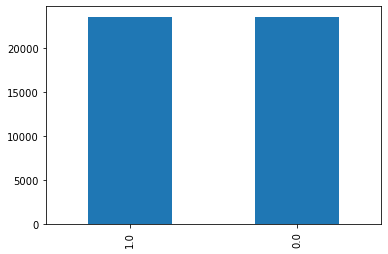

In [99]:
plot_y = pd.DataFrame(y_train, columns = ['Weather'])
after_processed = plot_y['Weather'].value_counts().plot(kind='bar')

#### Downsampling

In [27]:
from imblearn.under_sampling import TomekLinks

In [450]:
tl = TomekLinks(sampling_strategy='majority')

In [451]:
x_train_std, y_train=tl.fit_resample(x_train_std, y_train)

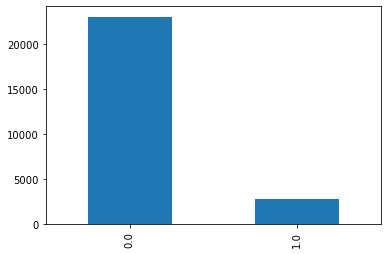

In [34]:
plot_y = pd.DataFrame(y_train_tl, columns = ['Weather'])
after_processed = plot_y['Weather'].value_counts().plot(kind='bar')

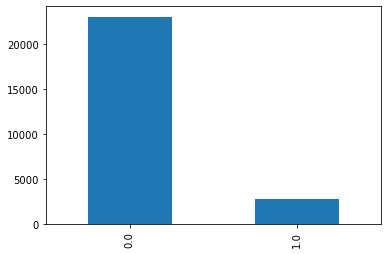

In [59]:
plot_y = pd.DataFrame(y_train, columns = ['Weather'])
after_processed = plot_y['Weather'].value_counts().plot(kind='bar')

## Light BGM

In [273]:
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [3,4,5,6,7,8,9,10],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lg, n_jobs=8, param_grid=param_dist, cv = 3, scoring="f1", verbose=5)

NameError: name 'GridSearchCV' is not defined

In [104]:
grid_search.fit(x_train_std,y_train)
grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] Number of positive: 23622, number of negative: 23622
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 47244, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(max_depth=10, n_estimators=200, num_leaves=900, silent=False)

In [452]:
lbgm=lgb.LGBMClassifier(max_depth=10, n_estimators=200, scale_pos_weight=4, num_leaves=20)

In [453]:
lbgm.fit(x_train_std,y_train)

LGBMClassifier(max_depth=10, n_estimators=200, num_leaves=20,
               scale_pos_weight=4)

In [454]:
y_pred_lbgm = lbgm.predict(x_val_std)
print('Accuracy: %f' % accuracy_score(y_val, y_pred_lbgm))
print('f1-score: %f' % f1_score(y_val, y_pred_lbgm))

Accuracy: 0.861645
f1-score: 0.450271


In [420]:
y_pred_lbgm = lbgm.predict(x_val_std)
print('Accuracy: %f' % accuracy_score(y_val, y_pred_lbgm))
print('f1-score: %f' % f1_score(y_val, y_pred_lbgm))

Accuracy: 0.847537
f1-score: 0.464000


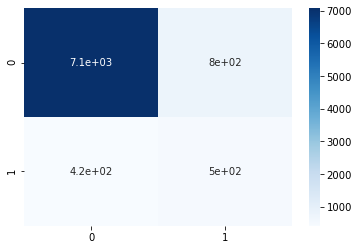

In [455]:
cm=confusion_matrix(y_val,y_pred_lbgm)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,cmap='Blues')

## Craete Ans 

In [351]:
ans_pred = lbgm.predict(x_test_std)
df_sap = pd.DataFrame(ans_pred.astype(int), columns = ['Weather'])
df_sap.to_csv('lbgm_tl_med_one_hot.csv',  index_label = 'Id')